In [2]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.defences.detector.poison import ActivationDefence
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset, to_categorical
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pprint
import json

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [3]:
# Loading data
(train_images_original, train_labels_original), (test_images_original, test_labels_original), min, max = load_dataset(name="mnist")

## Visualizing the data

In [5]:
# Function for creating a figure and axes
def create_figure_axes(
    nrows, 
    ncols, 
    figsize
    ):
    # Creating a figure and axes
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Returning the figure and axes
    return fig, axes

In [6]:
# Function for plotting images
def plot_images(
    images,
    labels,    
    plot_label,
    is_categorical,
    nrows, 
    ncols,
    figsize
    ):    
    # Creating a figure and axes
    fig, axes = create_figure_axes(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Defining a counting variable
    counter = 0

    # Iterating over our rows and cols,
    # plotting poisoned test images
    # along with their true targets
    for i in range(nrows):
        for j in range(ncols):
            # Converting the current label to an integer 
            # if it is categorical
            if is_categorical:
                label = np.argmax(a=labels[counter])
            else:
                label = labels[counter]
            
            # Displaying the current image
            # and setting axis title
            axes[i, j].imshow(images[counter])
            axes[i, j].set_title(label=f"{plot_label}: {label}")

            # Disabling ticks
            axes[i, j].set_xticks(ticks=[])
            axes[i, j].set_yticks(ticks=[])

            # Incrementing the counter
            counter += 1

In [7]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu", strides=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        Conv2D(filters=64, kernel_size=3, activation="relu", strides=2),
        Flatten(),
        Dense(units=100, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )   

    # Returning the model
    return model

# The Trainer Defense in ART

## Training vulnerable and robust models

In [8]:
# Importing dependencies
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod

# Initializing a vulnerable classsifier
vulnerable_classifier = KerasClassifier(
    model=create_model(), 
    clip_values=(min, max)
    )

# Initializing a robust classifier
robust_classifier = KerasClassifier(
    model=create_model(), 
    clip_values=(min, max)
    )

In [9]:
# Training the vulnerable classifier
vulnerable_classifier.fit(
    x=train_images_original[:10000], 
    y=train_labels_original[:10000], 
    nb_epochs=10
    )

In [10]:
# Initializing a Fast Gradient Method attack
attack_fgm = FastGradientMethod(
    estimator=vulnerable_classifier, 
    eps=0.15
    )

In [11]:
# Initializing an adversarial trainer to train
# a robust model
trainer = AdversarialTrainer(
    classifier=robust_classifier, 
    attacks=attack_fgm, 
    ratio=0.5
    )

In [12]:
# Training the robust classifier
trainer.fit(
    x=train_images_original[:10000], 
    y=train_labels_original[:10000],
    nb_epochs=10
    )

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

## Evaluating the effectiveness of the trainer

In [13]:
# Generating adversarial samples
test_images_fgm = attack_fgm.generate(x=test_images_original)

C:\Users\Darshan Mourya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
# Evaluating the performance of the vulnerable classier on clean and adversarial images
score_clean = vulnerable_classifier._model.evaluate(x=test_images_original, y=test_labels_original)
score_fgm = vulnerable_classifier._model.evaluate(x=test_images_fgm, y=test_labels_original)

# Comparing test losses
print("------ TEST METRICS OF VULNERABLE MODEL ------")
print(f"Clean test loss: {score_clean[0]:.2f} " 
      f"vs FGM test loss: {score_fgm[0]:.2f}")

# Comparing test accuracies
print(f"Clean test accuracy: {score_clean[1]:.2f} " 
      f"vs FGM test accuracy: {score_fgm[1]:.2f}")

C:\Users\Darshan Mourya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


------ TEST METRICS OF VULNERABLE MODEL ------
Clean test loss: 0.10 vs FGM test loss: 2.23
Clean test accuracy: 0.98 vs FGM test accuracy: 0.52


In [15]:
# Evaluating the performance of the robust classifier on adversarial images
score_robust_fgm = robust_classifier._model.evaluate(x=test_images_fgm, y=test_labels_original)

# Comparing test losses
print("------ TEST METRICS OF ROBUST VS VULNERABLE MODEL ON ADVERSARIAL SAMPLES ------")
print(f"Robust model test loss: {score_robust_fgm[0]:.2f} " 
      f"vs model vulnerable test loss: {score_fgm[0]:.2f}")

# Comparing test accuracies
print(f"Robust model test accuracy: {score_robust_fgm[1]:.2f} " 
      f"vs model vulnerable test accuracy: {score_fgm[1]:.2f}")

------ TEST METRICS OF ROBUST VS VULNERABLE MODEL ON ADVERSARIAL SAMPLES ------
Robust model test loss: 0.13 vs model vulnerable test loss: 2.23
Robust model test accuracy: 0.97 vs model vulnerable test accuracy: 0.52


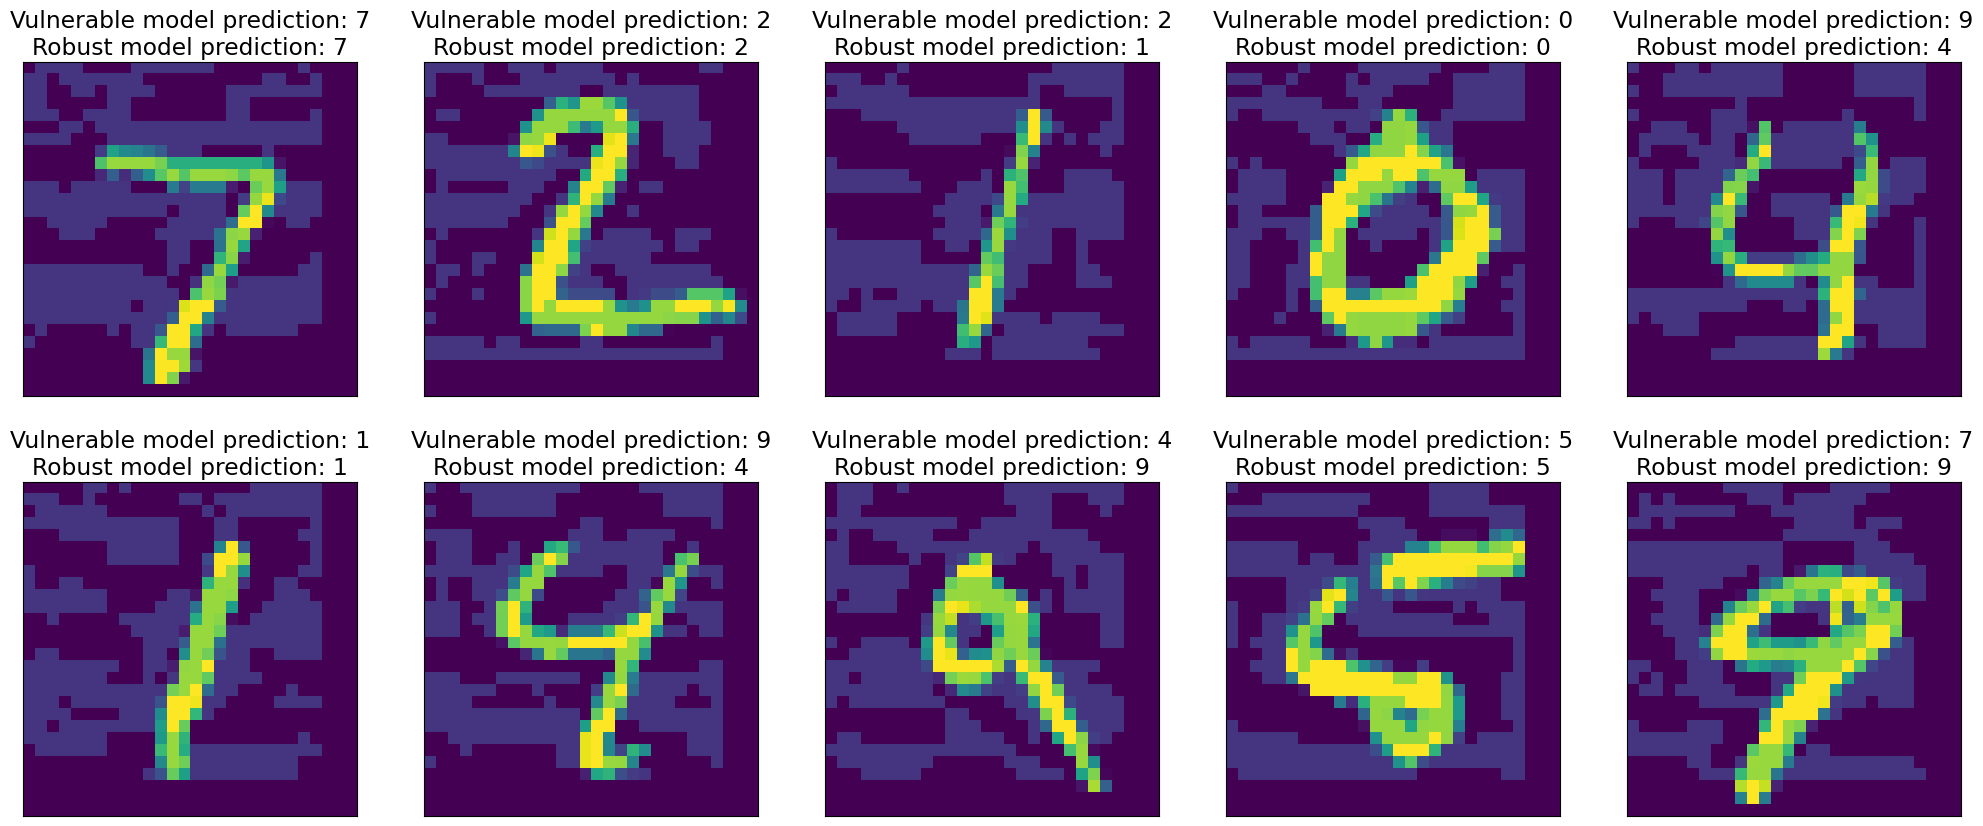

In [16]:
# Setting the number of rows and columns for the plot
nrows=2
ncols=5

# Creating a plot figure and axes for samples
fig, axes = create_figure_axes(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(25, 10)
    )

# Getting predictions for adversarial samples
victim_predictions = vulnerable_classifier.predict(x=test_images_fgm)
robust_predictions = robust_classifier.predict(x=test_images_fgm)

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting adversarial images
# along with their predictions
for i in range(nrows):
    for j in range(ncols):
        # Plotting the current image
        axes[i, j].imshow(test_images_fgm[counter])

        # Setting axis title
        axes[i, j].set_title(label=f"Vulnerable model prediction: {np.argmax(victim_predictions[counter])}\n"
                                   f"Robust model prediction: {np.argmax(robust_predictions[counter])}")
        
        # Disabling axis ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1